In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import analyze_cells_energy as ace
import re
import utils
import itertools
import seaborn as sns
import utils_PLS as upls

In [3]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [4]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'WILD_with_father'
batch='WILD_with_father2500'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_WILD_with_father2500.npy', 
                                   allow_pickle=True).item()

In [5]:
dict_results_across_mice = upls.reformat_dict_acronym(dict_results=dict_results_across_mice, volumes=volumes)

In [6]:
# remove unclean data
dict_results_across_mice.pop('W8Fam')

,area,n_cells,energy,density,relative_density,acronym
0,Frontal pole cerebral cortex,743,2.103171e+06,1361.994644,3.138133,FRP
1,Primary motor area,3250,8.268266e+05,548.930948,1.264776,MOp
2,Secondary motor area,3647,9.629560e+05,533.342677,1.228860,MOs
3,Primary somatosensory area,10027,1.299019e+06,801.136048,1.845875,SSp
4,Supplemental somatosensory area,2965,1.045813e+06,628.371420,1.447813,SSs
...,...,...,...,...,...,...
194,Interfascicular nucleus raphe,89,1.567883e+06,877.162363,2.021045,IF
195,Interpeduncular nucleus,95,4.557648e+05,246.900211,0.568876,IPN
196,Rostral linear nucleus raphe,4,8.893147e+04,59.337093,0.136717,RL
197,Central linear nucleus raphe,39,9.138680e+05,410.155287,0.945027,CLI


# Format data for task PLS

In [7]:
data_ncells = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                   batch=batch, table='n_cells')
data_energy = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                   batch=batch, table='energy')
data_density = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                    batch=batch, table='density')
data_relative_density = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                             batch=batch, table='relative_density')
data_ncells.dropna(inplace=True, axis=1)
data_energy.dropna(inplace=True, axis=1)
data_density.dropna(inplace=True, axis=1)
data_relative_density.dropna(inplace=True, axis=1)
data_ncells.to_csv('./results_pls/'+batch+'_n_cells.csv')
data_energy.to_csv('./results_pls/'+batch+'_energy.csv')
data_density.to_csv('./results_pls/'+batch+'_density.csv')
data_relative_density.to_csv('./results_pls/'+batch+'_relative_density.csv')

# Format data for hierarchy plotting

In [8]:
df_levels = upls.create_df_levels(volumes)

# Apply task PLS

In [9]:
%%bash
python area_pls.py -i results_pls/WILD_with_father2500_n_cells.csv -o './results_pls/WILD_with_father2500_ncells'

In [10]:
%%bash
python area_pls.py -i results_pls/WILD_with_father2500_energy.csv -o './results_pls/WILD_with_father2500_energy'

In [11]:
%%bash
python area_pls.py -i results_pls/WILD_with_father2500_density.csv -o './results_pls/WILD_with_father2500_density'

In [12]:
%%bash
python area_pls.py -i results_pls/WILD_with_father2500_relative_density.csv -o './results_pls/WILD_with_father2500_relative_density'

# PLS ncells

In [13]:
contrasts = pd.read_csv('./results_pls/WILD_with_father_contrasts.csv')
saliences = pd.read_csv('./results_pls/WILD_with_father_saliences.csv')
contrasts = contrasts.rename(columns={"group_Control": "Control", "group_Fam": "Fam", "group_Unfam":"Unfam"})

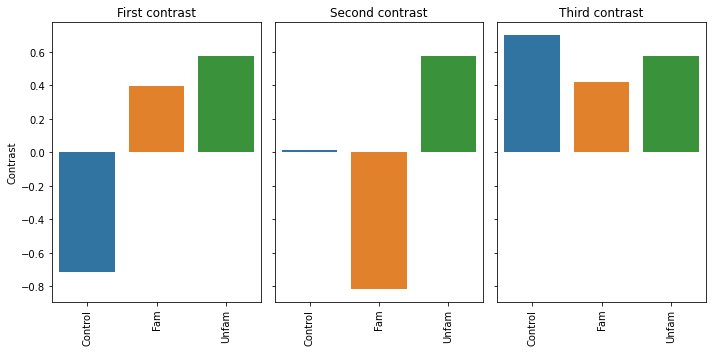

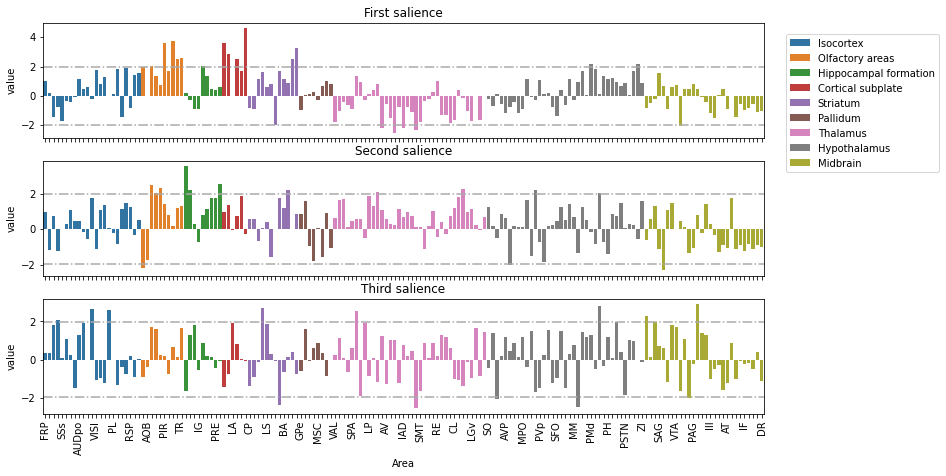

In [14]:
upls.plot_panel_contrasts(batch=batch, variable='ncells')
upls.plot_panel_saliences(batch=batch, variable='ncells', df_levels=df_levels)

# PLS energy

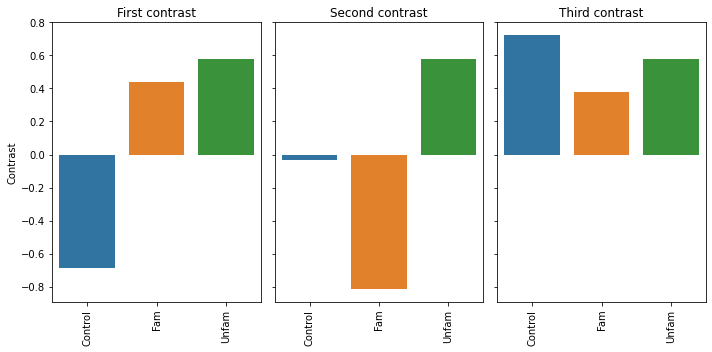

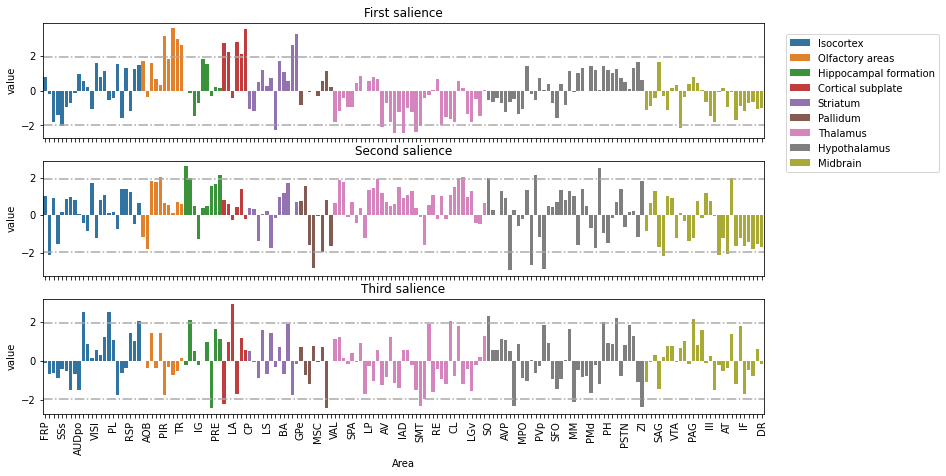

In [15]:
upls.plot_panel_contrasts(batch=batch, variable='energy')
upls.plot_panel_saliences(batch=batch, variable='energy', df_levels=df_levels)

# PLS density

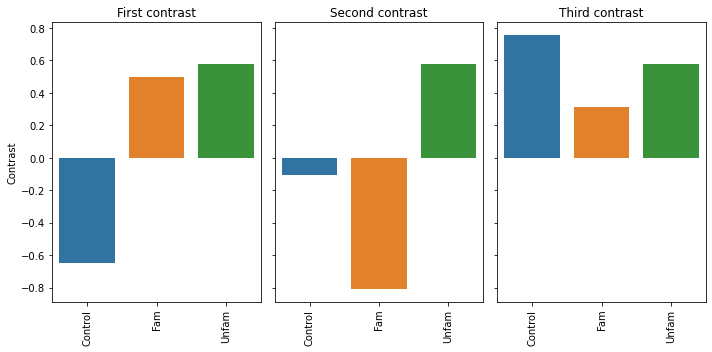

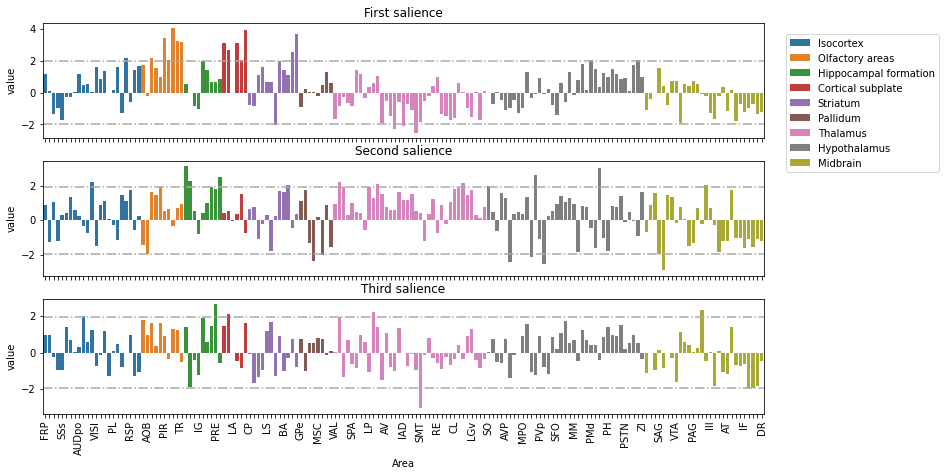

In [16]:
upls.plot_panel_contrasts(batch=batch, variable='density')
upls.plot_panel_saliences(batch=batch, variable='density', df_levels=df_levels)

# PLS relative density

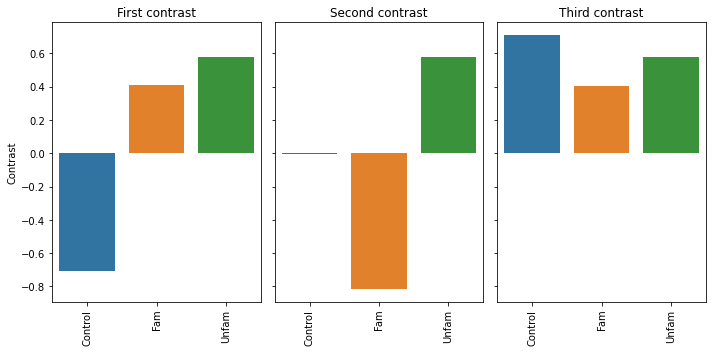

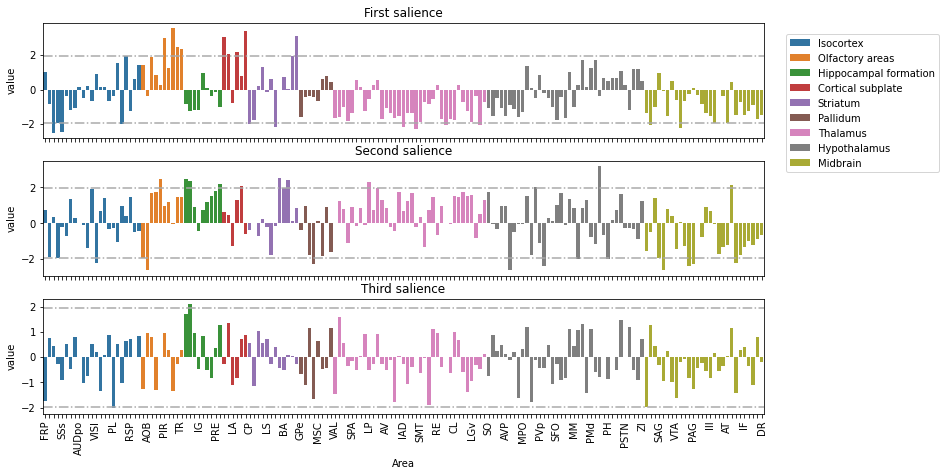

In [17]:
upls.plot_panel_contrasts(batch=batch, variable='relative_density')
upls.plot_panel_saliences(batch=batch, variable='relative_density', df_levels=df_levels)

# Identify areas with significant area contribution

In [18]:
pls_sig_areas = upls.identify_pls_sig_areas(saliences=saliences, 
                                       threshold=1.96, 
                                       volumes=volumes)
np.save('results_pls/pls_sig_areas_WILD_with_father.npy', pls_sig_areas)

In [19]:
pls_sig_areas = np.load('results_pls/pls_sig_areas_WILD_with_father.npy', allow_pickle=True)
pls_sig_areas

array(["Ammon's horn", 'Anterior amygdalar area',
       'Anterior cingulate area', 'Anterior olfactory nucleus',
       'Anterodorsal nucleus', 'Anteromedial visual area',
       'Anteroventral periventricular nucleus',
       'Arcuate hypothalamic nucleus', 'Basolateral amygdalar nucleus',
       'Central amygdalar nucleus', 'Claustrum',
       'Cortical amygdalar area', 'Dentate gyrus',
       'Dorsal peduncular area', 'Dorsal premammillary nucleus',
       'Endopiriform nucleus', 'Entorhinal area',
       'Interanterodorsal nucleus of the thalamus',
       'Intercalated amygdalar nucleus', 'Lateral amygdalar nucleus',
       'Lateral preoptic area', 'Main olfactory bulb',
       'Medial amygdalar nucleus', 'Mediodorsal nucleus of thalamus',
       'Midbrain reticular nucleus retrorubral area',
       'Nucleus of the brachium of the inferior colliculus',
       'Olfactory tubercle', 'Parabigeminal nucleus',
       'Parastrial nucleus',
       'Paraventricular hypothalamic nucleus de

In [20]:
overlap = {'ncells':[], 'energy':[], 'density':[], 'relative_density':[]}
for variable in overlap.keys():
    overlap[variable] = set(upls.identify_pls_sig_areas(saliences=pd.read_csv(
        './results_pls/'+ batch +'_'+ variable +'_saliences.csv'), 
                                           threshold=1.96, 
                                           volumes=volumes))
[len(overlap[key]) for key in overlap.keys()]

[46, 52, 47, 45]

In [21]:
overlap['relative_density']

{'Accessory olfactory bulb',
 "Ammon's horn",
 'Anterior amygdalar area',
 'Anterior tegmental nucleus',
 'Anteroventral periventricular nucleus',
 'Basolateral amygdalar nucleus',
 'Basomedial amygdalar nucleus',
 'Caudoputamen',
 'Central amygdalar nucleus',
 'Central medial nucleus of the thalamus',
 'Claustrum',
 'Cortical amygdalar area',
 'Dentate gyrus',
 'Dorsal peduncular area',
 'Endopiriform nucleus',
 'Inferior colliculus',
 'Interanterodorsal nucleus of the thalamus',
 'Lateral posterior nucleus of the thalamus',
 'Lateral terminal nucleus of the accessory optic tract',
 'Lateral visual area',
 'Magnocellular nucleus',
 'Medial amygdalar nucleus',
 'Medial habenula',
 'Mediodorsal nucleus of thalamus',
 'Midbrain reticular nucleus retrorubral area',
 'Orbital area',
 'Parabigeminal nucleus',
 'Parastrial nucleus',
 'Paraventricular hypothalamic nucleus descending division',
 'Periaqueductal gray',
 'Periventricular hypothalamic nucleus preoptic part',
 'Piriform area',
 'P

In [22]:
# union between areas significant in all analyses
all_areas = overlap['ncells'].union(overlap['energy']).union(overlap['density']).union(overlap['relative_density'])
# intersection between areas significant in all analyses
intersection = overlap['ncells'].intersection(overlap['energy']).intersection(
    overlap['density']).intersection(overlap['relative_density'])
# filtering
intersection, len(intersection)

({"Ammon's horn",
  'Anteroventral periventricular nucleus',
  'Basolateral amygdalar nucleus',
  'Claustrum',
  'Cortical amygdalar area',
  'Dentate gyrus',
  'Endopiriform nucleus',
  'Interanterodorsal nucleus of the thalamus',
  'Medial amygdalar nucleus',
  'Mediodorsal nucleus of thalamus',
  'Parabigeminal nucleus',
  'Parastrial nucleus',
  'Paraventricular hypothalamic nucleus descending division',
  'Piriform area',
  'Piriform-amygdalar area',
  'Posterior amygdalar nucleus',
  'Postpiriform transition area',
  'Septohippocampal nucleus',
  'Subiculum'},
 19)

In [23]:
overlap['relative_density']

{'Accessory olfactory bulb',
 "Ammon's horn",
 'Anterior amygdalar area',
 'Anterior tegmental nucleus',
 'Anteroventral periventricular nucleus',
 'Basolateral amygdalar nucleus',
 'Basomedial amygdalar nucleus',
 'Caudoputamen',
 'Central amygdalar nucleus',
 'Central medial nucleus of the thalamus',
 'Claustrum',
 'Cortical amygdalar area',
 'Dentate gyrus',
 'Dorsal peduncular area',
 'Endopiriform nucleus',
 'Inferior colliculus',
 'Interanterodorsal nucleus of the thalamus',
 'Lateral posterior nucleus of the thalamus',
 'Lateral terminal nucleus of the accessory optic tract',
 'Lateral visual area',
 'Magnocellular nucleus',
 'Medial amygdalar nucleus',
 'Medial habenula',
 'Mediodorsal nucleus of thalamus',
 'Midbrain reticular nucleus retrorubral area',
 'Orbital area',
 'Parabigeminal nucleus',
 'Parastrial nucleus',
 'Paraventricular hypothalamic nucleus descending division',
 'Periaqueductal gray',
 'Periventricular hypothalamic nucleus preoptic part',
 'Piriform area',
 'P